In [1]:
from fastai.vision.all import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
path = Path('/kaggle/input/wikiart-art-movementsstyles')  
print(type(path))

<class 'pathlib.PosixPath'>


In [3]:
# Tạo ImageDataLoaders
dls = ImageDataLoaders.from_folder(
    path,                     # Thư mục gốc
    valid_pct=0.2,            # Chia 20% dữ liệu cho tập valid
    seed=42,                  # Đảm bảo chia dữ liệu ngẫu nhiên nhưng có thể tái lặp
    item_tfms=Resize(224),    # Resize hình ảnh về kích thước 224x224
    batch_tfms=aug_transforms( # Transform áp dụng trên batch
        flip_vert=True,
        max_rotate=10,
        max_zoom=1.2,
        max_lighting=0.2,
        max_warp=0.2
    ),
    # bs=128        # Batch size (mặc định là 64)
)

In [4]:
from timm import create_model
# vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=dls.c)
vit_model = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=dls.c)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

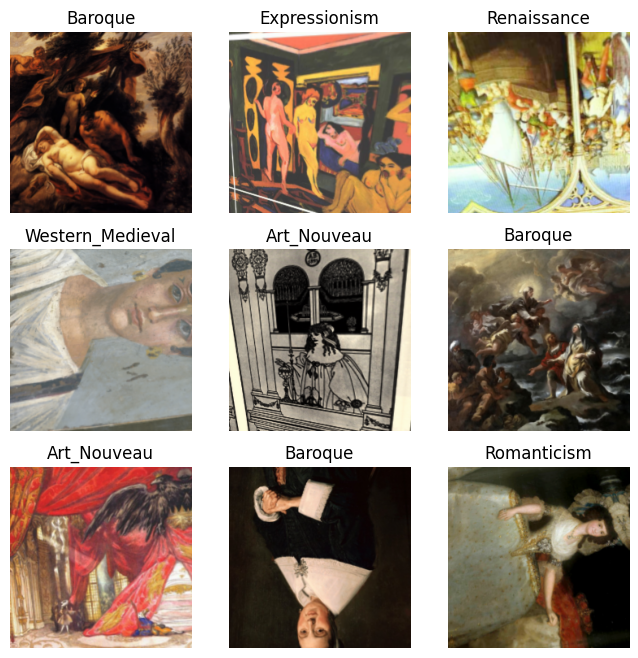

In [5]:
dls.show_batch(max_n=9, figsize=(8, 8))

In [6]:
#make it float instead of long int
from fastai.callback.mixup import MixUp
from fastai.callback.mixup import CutMix

class FixedMixUp(MixUp):
    def __init__(self, alpha=0.2, lambda_val=None):
        super().__init__(alpha=alpha)
        self.lambda_val = lambda_val

    def before_batch(self):
        super().before_batch()
        self.lam = self.lam.float().to(self.dls.device)

class FixedCutMix(CutMix):
    def before_batch(self):
        super().before_batch()
        self.lam = self.lam.float().to(self.dls.device)


mixup_cb = FixedMixUp(alpha=0.5, lambda_val=0.5)
cutmix_cb = FixedCutMix(alpha=0.5)

In [7]:
from fastai.losses import LabelSmoothingCrossEntropy

learn = Learner(
    dls, vit_model.cuda(), 
    metrics=accuracy, 
    cbs=[mixup_cb],  
    #loss_func=LabelSmoothingCrossEntropy(),
    path='/kaggle/working',  
    model_dir='/kaggle/working/models'
)

In [8]:
learn.dls.cuda()

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

result: SuggestedLRs(valley=5.248074739938602e-05)


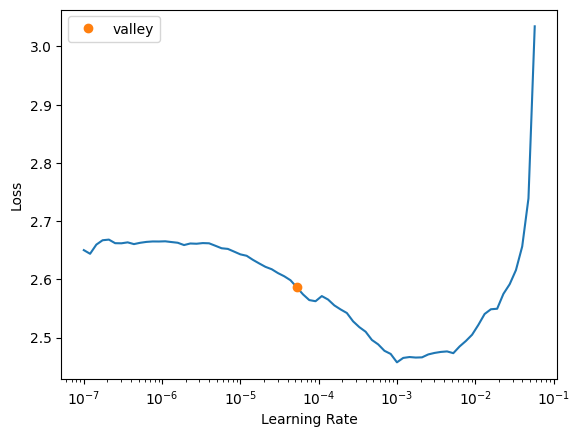

In [9]:
#finds the ideal learning rate
lr_result = learn.lr_find()
print("result:",lr_result)

In [10]:
learn.fine_tune(10, base_lr=lr_result.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.563187,0.973450,0.684235,16:26


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,1.329727,0.814602,0.733882,16:02
1,1.273477,0.736349,0.764588,15:36
2,1.211928,0.670129,0.784353,15:32
3,1.149899,0.627776,0.801294,15:57
4,1.070813,0.584342,0.811765,15:39
5,1.023884,0.526539,0.834824,15:41
6,0.982848,0.515874,0.837294,15:34
7,0.936351,0.497026,0.843059,15:43
8,0.915824,0.495777,0.846706,15:31
9,0.906362,0.493551,0.849294,15:47


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: Dec

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

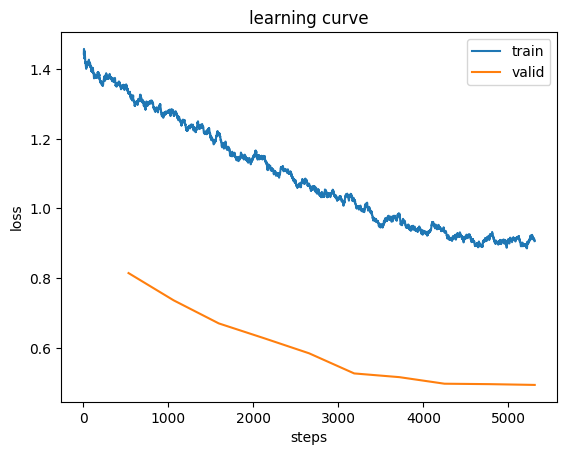

In [11]:
learn.recorder.plot_loss()

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


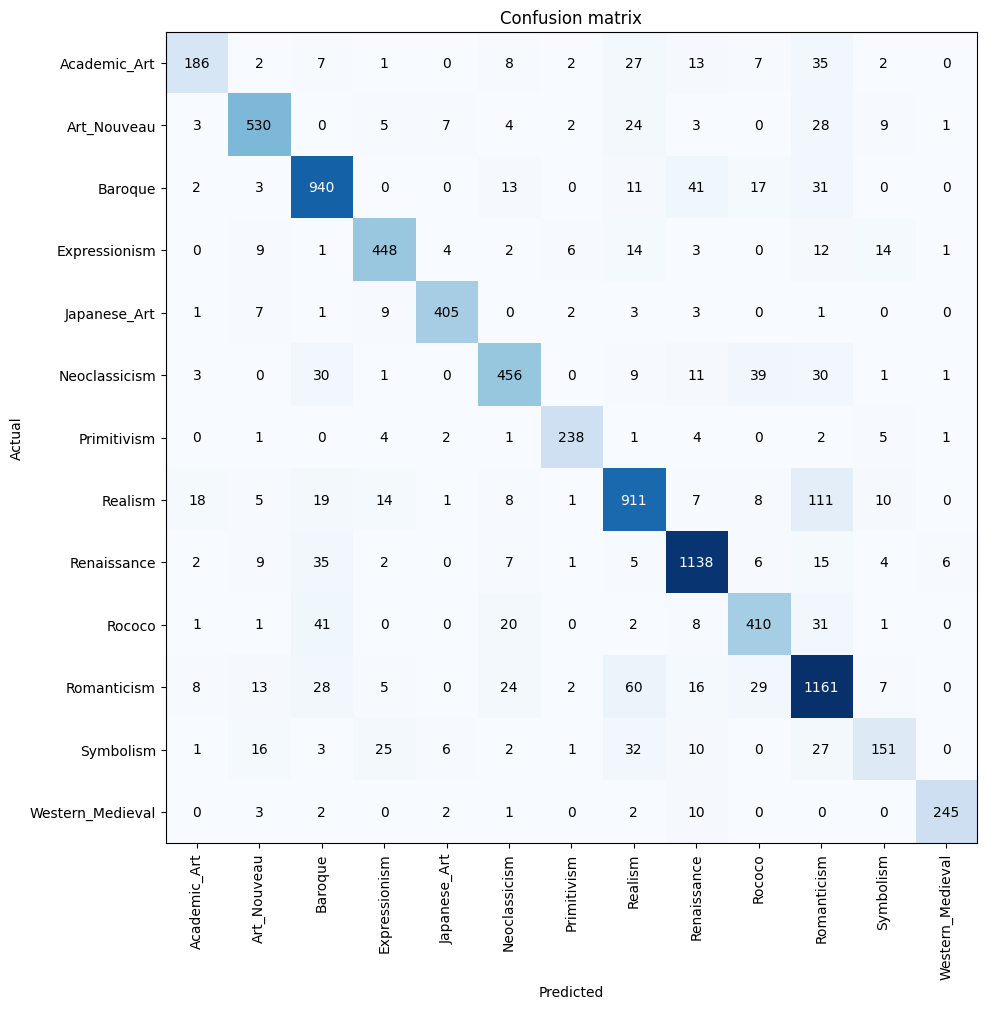

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lấy dự đoán và nhãn thực tế từ mô hình
preds, targs = learn.get_preds()

# Chuyển đổi dự đoán xác suất thành nhãn
y_pred = preds.argmax(dim=1).numpy()
y_true = targs.numpy()

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Accuracy: 0.8493
Precision: 0.8493
Recall: 0.8493
F1 Score: 0.8480


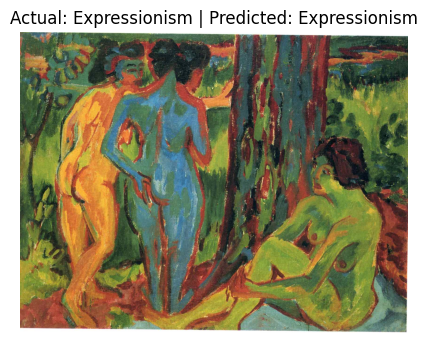

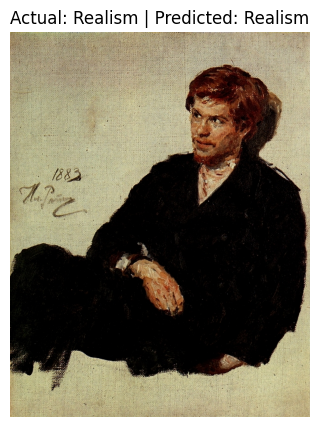

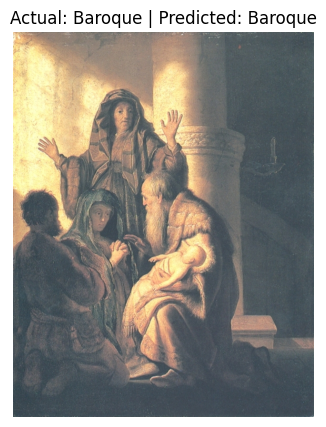

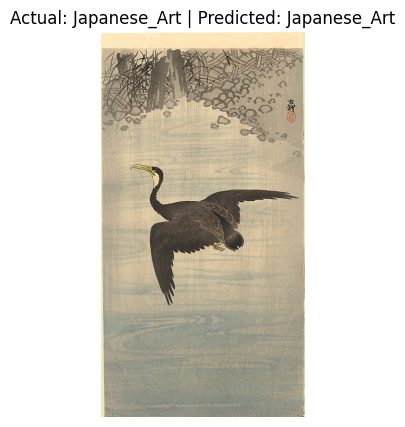

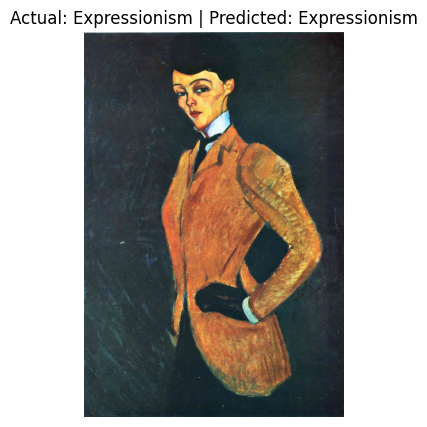

In [14]:
import random
from fastai.vision.all import *

# Số lượng ảnh muốn hiển thị
n_samples = 5

# Chọn ngẫu nhiên các index từ tập valid
random_idxs = random.sample(range(len(dls.valid_ds)), n_samples)

# Hiển thị các ảnh cùng với nhãn thực tế và dự đoán
for idx in random_idxs:
    img, label = dls.valid_ds[idx]
    pred = learn.predict(img)[0]  # Lấy nhãn dự đoán
    
    # Hiển thị ảnh
    img.show(title=f"Actual: {dls.vocab[label]} | Predicted: {pred}")


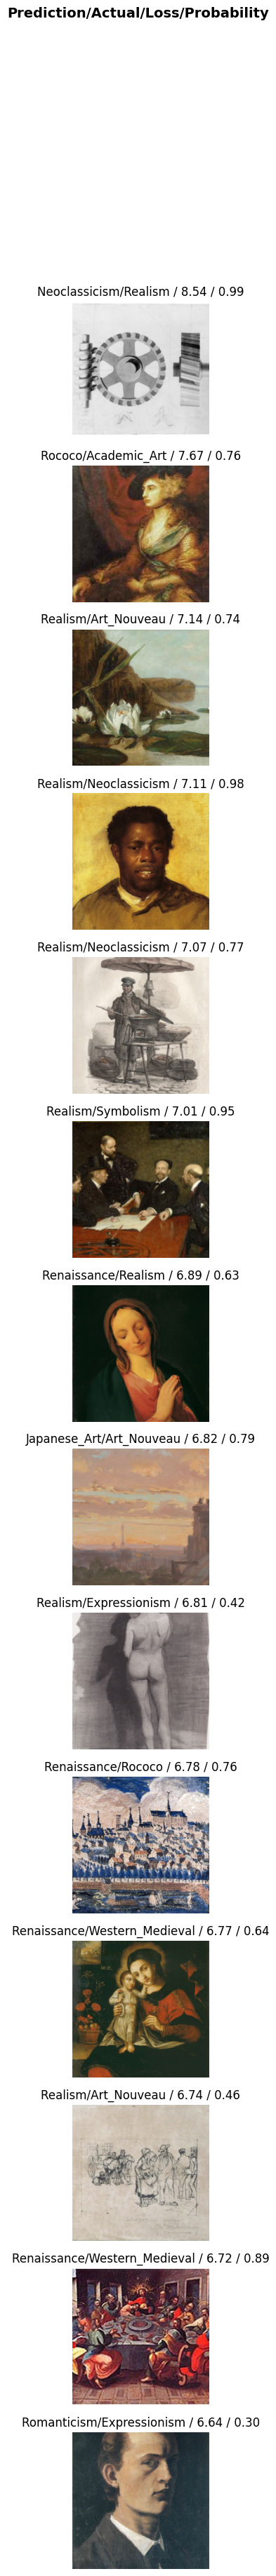

In [15]:
interp.plot_top_losses(14, nrows=14)